# Crash Course in Causality with NYC Taxi Trips
### From Raw Trips to Credible Causal Claims

**Author:** Jaswanth Gurujala  
**Context:** Educational notebook for understanding causal inference and causally-aware data preparation using real data.

This notebook is designed as a guided crash course.  
We will:

1. Introduce core causal concepts (treatment, outcome, confounders, backdoor paths).
2. Explore the NYC Yellow Taxi dataset.
3. Show how **data cleaning, feature engineering, and encoding** are *causal modeling choices*.
4. Estimate and interpret the effect of **peak-hour pickups on trip duration** using:
   - naive comparison,
   - adjusted regression,
   - a simple causal inference workflow with DoWhy.


## What is Causality (and Why It Matters for NYC Taxi Trips)?

Most of the time when we look at data, we see **patterns**:

- Trips at 5–6 pm are longer on average.
- Trips from certain locations cost more.
- More distance usually means more time.

These are **correlations**: things that move together.

**Causality** goes one step further. It asks:

> *If we changed something, would the outcome actually change because of that?*

In other words:

- **Causal effect** = cause → effect  
- **Non-causal pattern** = they just happen to be related (maybe because of some other factor).

### In this notebook

Our concrete causal question is:

> **Does being picked up during weekday peak hours cause trips to take longer, for similar trips?**

To talk about that in a causal way, we define:

- **Treatment (T):** `is_peak_hour`  
  - 1 if the trip starts in a defined peak-hour window (weekday rush hours),  
  - 0 otherwise.
- **Outcome (Y):** `trip_duration_min`  
  - how many minutes the trip actually took.
- **Confounders (C):** variables that can affect both T and Y, such as:
  - `trip_distance` (longer trips are slower and may be more common at certain times),
  - `pickup_hour` and `pickup_dayofweek` (time structure),
  - `PULocationID` (pickup zone / congestion),
  - `passenger_count` (behavioral patterns).

Why do these matter?

If peak-hour trips are also **longer distance** or come from **busier areas**, then peak vs off-peak differences in duration are not purely “because of traffic” — they’re mixed with those other factors.

So, throughout this notebook:

- We **clean** and **engineer** these variables.
- We use them to **adjust** our comparisons.
- This lets us move from:
  - “Peak trips look longer” (correlation)
  - to
  - “Given similar distance, time, and location, peak-hour pickup adds about X minutes” (a causal claim, under clear assumptions).

That is how causality is applied to our NYC Taxi dataset.


## Abstract

Most machine learning notebooks stop at "clean → train → predict".  
Causal analysis asks a different question:

> What happens if we **intervene**?

Using NYC Yellow Taxi data, this notebook walks through an end-to-end, causality-aware workflow. We:

- Define a clear causal question:
  > Does being picked up during weekday peak hours increase trip duration, after accounting for distance, time, and location?
- Connect this question to causal concepts:
  - Treatment, outcome, confounders, backdoor paths.
- Prepare the data in a way that respects those concepts:
  - Construct treatment and outcome variables.
  - Handle missing and implausible values.
  - Engineer and encode confounders.
- Visualize the data (distributions, relationships, correlation heatmaps) to understand structure.
- Estimate the effect with transparent models and discuss assumptions.

The goal is not just to get a number, but to show how **every preprocessing step is part of the causal story**.


In [ ]:
# Install dependencies (for Colab)
!apt-get install -y graphviz > /dev/null
!pip install dowhy econml --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from dowhy import CausalModel

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

# Reproducibility (for sampling / models)
np.random.seed(42)


## 1. Causality in One Page

### 1.1 Predictive vs Causal Questions

**Predictive ML question**

> Given pickup time, distance, and location, can we predict trip duration?

Good for forecasting. Not enough to answer "what if" questions.

**Causal question**

> If the *same kind of trip* happened during peak hours instead of off-peak, how much longer would it take?

Now we care about **interventions**:
- Not just patterns in historical data,
- But what would happen under a hypothetical change.

### 1.2 Key Terms

We will use:

- **Treatment (T):** the variable we imagine intervening on.  
- **Outcome (Y):** what we care about changing.  
- **Confounder (C):** a variable that influences both T and Y.  
- **Backdoor path:** a non-causal path from T to Y through confounders.  
- **Backdoor adjustment:** conditioning on the right confounders to block those paths.

In this notebook:

- **T:** `is_peak_hour`  
- **Y:** `trip_duration_min`  
- **Candidate C:** `trip_distance`, `PULocationID`, `pickup_dayofweek`, `passenger_count`


## 2. Our Causal Story

We consider the effect of **peak-hour pickup** on **trip duration**.

- During peak hours, roads are more congested.
- But peak trips might also:
  - start in different locations,
  - be different distances,
  - happen on specific days,
  - involve different passenger patterns.

So if we just compare raw averages, we might mix:
- real congestion effect,
- differences in where and when people travel.

### 2.1 Informal DAG (verbal)

A plausible causal structure:

- `pickup_dayofweek` → `is_peak_hour`
- `pickup_dayofweek` → `trip_duration_min`
- `PULocationID` → `is_peak_hour`
- `PULocationID` → `trip_duration_min`
- `trip_distance` → `trip_duration_min`
- `trip_distance` → `is_peak_hour` (e.g., airport/business trips)
- `passenger_count` → `is_peak_hour`, `trip_duration_min`
- `is_peak_hour` → `trip_duration_min` (this is the effect we want)

This suggests we should adjust for:
`trip_distance`, `PULocationID`, `pickup_dayofweek`, `passenger_count`.

And this is exactly what will drive our data preparation.


In [ ]:
# 3. Load NYC Yellow Taxi Data (January 2023)

DATA_URL = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"

df_raw = pd.read_parquet(DATA_URL)
print("Full dataset shape:", df_raw.shape)

# Sample to keep the notebook fast but realistic
df = df_raw.sample(n=200_000, random_state=42).copy()
print("Sampled dataset shape:", df.shape)

df.head()


Full dataset shape: (3066766, 19)
Sampled dataset shape: (200000, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2790731,2,2023-01-29 17:52:02,2023-01-29 17:56:43,1.0,1.17,1.0,N,262,74,2,7.2,0.0,0.5,0.00,0.0,1.0,11.20,2.5,0.0
666153,1,2023-01-08 15:57:24,2023-01-08 16:02:47,1.0,0.90,1.0,N,229,237,2,6.5,2.5,0.5,0.00,0.0,1.0,10.50,2.5,0.0
1985683,2,2023-01-21 19:38:01,2023-01-21 19:45:02,1.0,0.95,1.0,N,45,261,1,7.9,0.0,0.5,2.38,0.0,1.0,14.28,2.5,0.0
2154231,2,2023-01-23 16:07:31,2023-01-23 16:26:46,5.0,0.88,1.0,N,237,141,1,16.3,2.5,0.5,1.50,0.0,1.0,24.30,2.5,0.0
2493619,2,2023-01-26 21:21:08,2023-01-26 21:24:48,2.0,1.03,1.0,N,229,140,1,6.5,1.0,0.5,2.30,0.0,1.0,13.80,2.5,0.0


## 4. First Look & Variable Selection

We restrict to columns needed for our causal question:

- pickup/dropoff times → define duration & treatment
- distance → key driver of duration
- passenger_count → potential confounder
- PULocationID/DOLocationID → spatial structure
- fare/tip → used for plausibility checks


In [ ]:
cols = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "passenger_count",
    "trip_distance",
    "PULocationID",
    "DOLocationID",
    "fare_amount",
    "tip_amount",
    "total_amount",
    "payment_type"
]

df = df[cols].copy()

print("Missing values (initial):")
print(df.isna().sum())
df.describe(include="all").T


Missing values (initial):
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          4598
trip_distance               0
PULocationID                0
DOLocationID                0
fare_amount                 0
tip_amount                  0
total_amount                0
payment_type                0
dtype: int64


,count,mean,min,25%,50%,75%,max,std
tpep_pickup_datetime,200000,2023-01-17 00:34:36.290830,2022-10-25 09:06:23,2023-01-09 16:20:36.250000,2023-01-17 08:31:29.500000,2023-01-24 16:41:13.250000,2023-01-31 23:59:47,NaN
tpep_dropoff_datetime,200000,2023-01-17 00:50:18.646030,2022-10-25 09:21:36,2023-01-09 16:33:52.750000,2023-01-17 08:47:57.500000,2023-01-24 16:56:33.750000,2023-02-01 22:17:19,NaN
passenger_count,195402.0,1.363113,0.0,1.0,1.0,1.0,6.0,0.894411
trip_distance,200000.0,3.442239,0.0,1.06,1.8,3.35,7729.75,21.428484
PULocationID,200000.0,166.49313,1.0,132.0,162.0,234.0,265.0,64.217538
DOLocationID,200000.0,164.377805,1.0,114.0,162.0,234.0,265.0,69.903375
fare_amount,200000.0,18.334122,-231.9,8.6,12.8,20.5,500.0,17.600321
tip_amount,200000.0,3.361763,-0.9,1.0,2.73,4.2,200.0,3.787229
total_amount,200000.0,26.974411,-254.95,15.4,20.16,28.7,501.0,21.948453
payment_type,200000.0,1.19412,0.0,1.0,1.0,1.0,4.0,0.526696


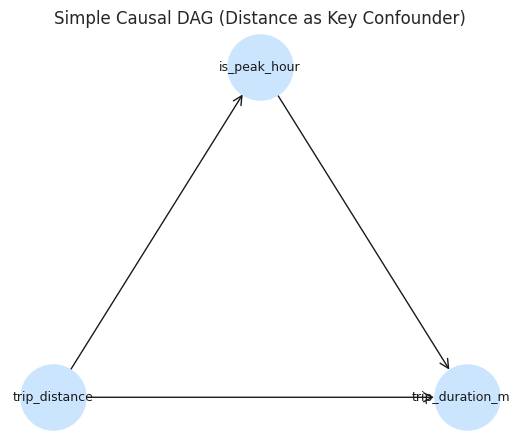

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Minimal causal story:
# trip_distance → is_peak_hour
# trip_distance → trip_duration_min
# is_peak_hour → trip_duration_min

dag_simple = nx.DiGraph()

# Nodes
dag_simple.add_nodes_from([
    "trip_distance",
    "is_peak_hour",
    "trip_duration_min"
])

# Edges (assumed causal relationships)
dag_simple.add_edge("trip_distance", "is_peak_hour")
dag_simple.add_edge("trip_distance", "trip_duration_min")
dag_simple.add_edge("is_peak_hour", "trip_duration_min")

# Layout: keep it very clean
pos = {
    "trip_distance": (-1, 0),
    "is_peak_hour": (0, 1),
    "trip_duration_min": (1, 0),
}

plt.figure(figsize=(5, 4))
nx.draw(
    dag_simple,
    pos,
    with_labels=True,
    node_size=2200,
    node_color="#cce5ff",
    arrows=True,
    arrowstyle="->",
    arrowsize=16,
    font_size=9
)
plt.title("Simple Causal DAG (Distance as Key Confounder)")
plt.axis("off")
plt.show()


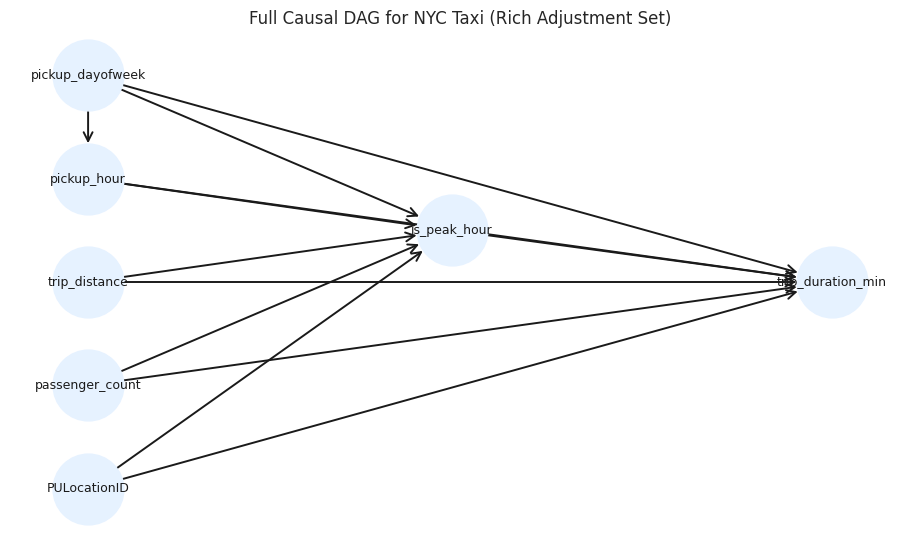

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

dag_full = nx.DiGraph()

# Nodes
dag_full.add_nodes_from([
    "pickup_dayofweek",
    "pickup_hour",
    "trip_distance",
    "passenger_count",
    "PULocationID",
    "is_peak_hour",        # Treatment
    "trip_duration_min"    # Outcome
])

# Edges based on our richer assumptions
edges_full = [
    # Calendar/time structure
    ("pickup_dayofweek", "pickup_hour"),
    ("pickup_dayofweek", "is_peak_hour"),
    ("pickup_dayofweek", "trip_duration_min"),

    # Time of day as confounder
    ("pickup_hour", "is_peak_hour"),
    ("pickup_hour", "trip_duration_min"),

    # Distance as confounder
    ("trip_distance", "is_peak_hour"),
    ("trip_distance", "trip_duration_min"),

    # Passenger behavior
    ("passenger_count", "is_peak_hour"),
    ("passenger_count", "trip_duration_min"),

    # Location / zones
    ("PULocationID", "is_peak_hour"),
    ("PULocationID", "trip_duration_min"),

    # Treatment -> Outcome
    ("is_peak_hour", "trip_duration_min")
]

dag_full.add_edges_from(edges_full)

# Manual layout for clarity: left = confounders, middle = treatment, right = outcome
pos = {
    "pickup_dayofweek": (0, 2),
    "pickup_hour":      (0, 1),
    "trip_distance":    (0, 0),
    "passenger_count":  (0, -1),
    "PULocationID":     (0, -2),
    "is_peak_hour":     (2.2, 0.5),
    "trip_duration_min":(4.5, 0),
}

plt.figure(figsize=(9, 5))
nx.draw(
    dag_full,
    pos,
    with_labels=True,
    node_size=2600,
    node_color="#e6f2ff",
    arrows=True,
    arrowstyle="->",
    arrowsize=16,
    font_size=9,
    width=1.4
)

plt.title("Full Causal DAG for NYC Taxi (Rich Adjustment Set)", fontsize=12)
plt.axis("off")
plt.show()


This layout makes the structure explicit:

- Left: potential confounders (`pickup_dayofweek`, `pickup_hour`, `trip_distance`, `passenger_count`, `PULocationID`)
- Middle: treatment (`is_peak_hour`)
- Right: outcome (`trip_duration_min`)

Arrows show why we adjust for these variables: they affect both `is_peak_hour` and `trip_duration_min`, so conditioning on them aims to block backdoor paths and isolate the causal effect of peak-hour pickup.


## 5. Data Preparation as a Causal Step

We now clean in a way that respects our causal story.

Principles:

1. If T, Y, or key confounders are undefined → that row cannot inform the effect.
2. Remove clearly impossible values (negative distances, zero fares) that are likely logging errors.
3. Keep rules transparent.


In [ ]:
# Drop rows with missing critical fields for our question
df = df.dropna(subset=[
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "trip_distance",
    "fare_amount",
    "passenger_count"
])

# Basic sanity filters
df = df[
    (df["trip_distance"] > 0) &
    (df["fare_amount"] > 0)
]

print("Shape after basic cleaning:", df.shape)


Shape after basic cleaning: (191392, 10)


## 6. Feature Engineering for Causal Analysis

We construct:

- **Outcome** `trip_duration_min`  
- **Time features**: `pickup_hour`, `pickup_dayofweek`, `is_weekday`  
- **Treatment** `is_peak_hour`:
  - Weekdays
  - 7–10 AM or 4–7 PM
- Optional: `tip_rate` for extended questions.


In [ ]:
# Convert to datetime
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

# Outcome: trip duration in minutes
df["trip_duration_min"] = (
    df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
).dt.total_seconds() / 60.0

# Time features
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
df["pickup_dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek  # 0=Mon
df["is_weekday"] = df["pickup_dayofweek"].isin([0,1,2,3,4]).astype(int)

# Treatment: is_peak_hour (weekday rush hours)
df["is_peak_hour"] = np.where(
    (df["is_weekday"] == 1) &
    ((df["pickup_hour"].between(7, 10)) | (df["pickup_hour"].between(16, 19))),
    1,
    0
)

# Optional tip_rate (for later exploration)
df["tip_rate"] = np.where(
    df["fare_amount"] > 0,
    df["tip_amount"] / df["fare_amount"],
    np.nan
)

# Filter implausible durations/distances
df = df[
    (df["trip_duration_min"] > 1) &
    (df["trip_duration_min"] < 180) &   # under 3 hours
    (df["trip_distance"] < 100)         # cut extreme distances
]

print("Shape after feature engineering & plausibility filters:", df.shape)
df[[
    "tpep_pickup_datetime",
    "trip_distance",
    "trip_duration_min",
    "pickup_hour",
    "pickup_dayofweek",
    "is_peak_hour"
]].head()


Shape after feature engineering & plausibility filters: (190635, 16)


,tpep_pickup_datetime,trip_distance,trip_duration_min,pickup_hour,pickup_dayofweek,is_peak_hour
2790731,2023-01-29 17:52:02,1.17,4.683333,17,6,0
666153,2023-01-08 15:57:24,0.90,5.383333,15,6,0
1985683,2023-01-21 19:38:01,0.95,7.016667,19,5,0
2154231,2023-01-23 16:07:31,0.88,19.250000,16,0,1
2493619,2023-01-26 21:21:08,1.03,3.666667,21,3,0


## 7. Exploratory Data Analysis

We first sanity-check the prepared data.

### 7.1 Distribution of Trip Duration


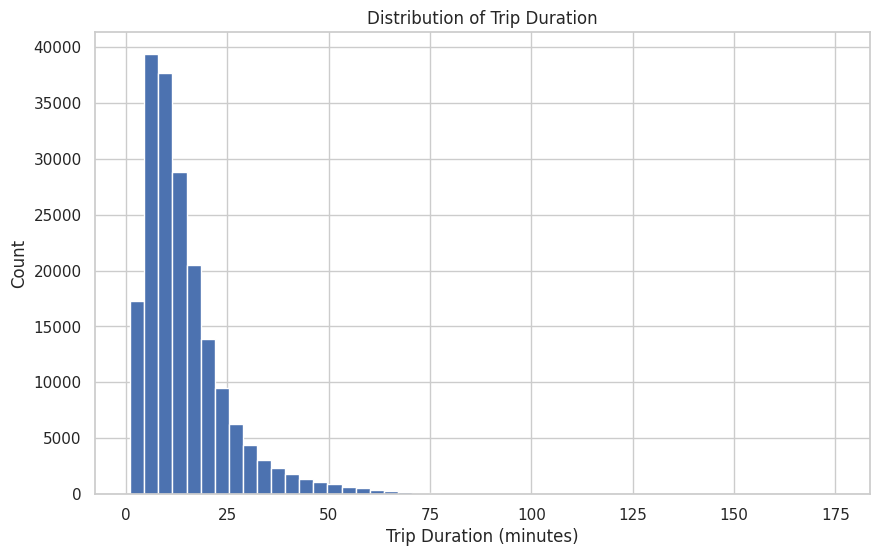

In [ ]:
plt.hist(df["trip_duration_min"], bins=50)
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Count")
plt.title("Distribution of Trip Duration")
plt.show()


### 7.2 Off-peak vs Peak Trip Counts


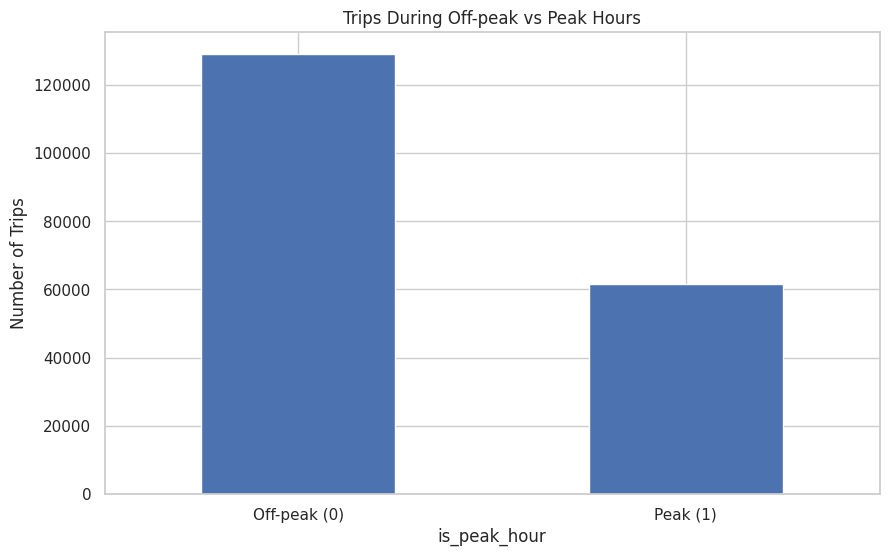

In [ ]:
df["is_peak_hour"].value_counts().sort_index().plot(kind="bar")
plt.xticks([0,1], ["Off-peak (0)", "Peak (1)"], rotation=0)
plt.ylabel("Number of Trips")
plt.title("Trips During Off-peak vs Peak Hours")
plt.show()


### 7.3 Trip Distance vs Duration (sample)

We expect a positive relationship; extreme noise here would warn us about remaining data quality issues.


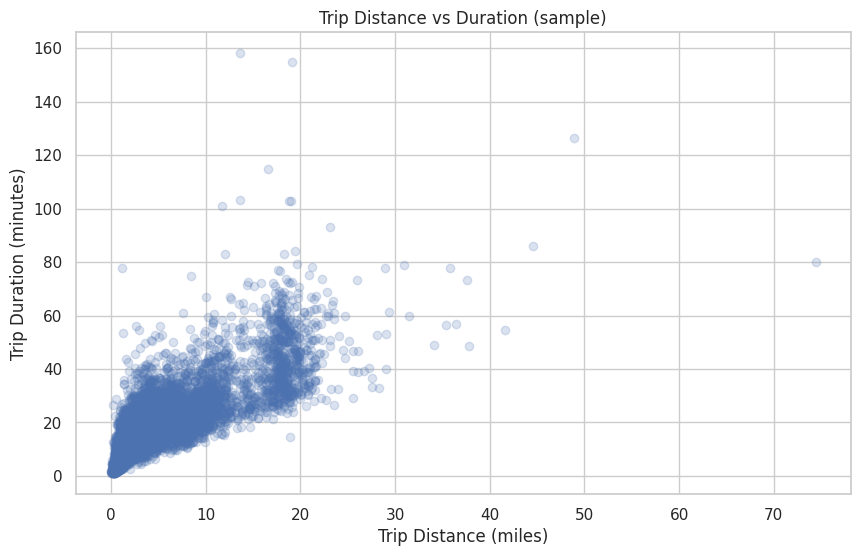

In [ ]:
sample_scatter = df.sample(n=15000, random_state=42)

plt.scatter(sample_scatter["trip_distance"], sample_scatter["trip_duration_min"], alpha=0.2)
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Trip Duration (minutes)")
plt.title("Trip Distance vs Duration (sample)")
plt.show()


### 7.4 Correlation Heatmap (Numeric Features)

This helps us see basic relationships, but remember:
> Correlation ≠ Causation.

We use it only as a diagnostic tool.


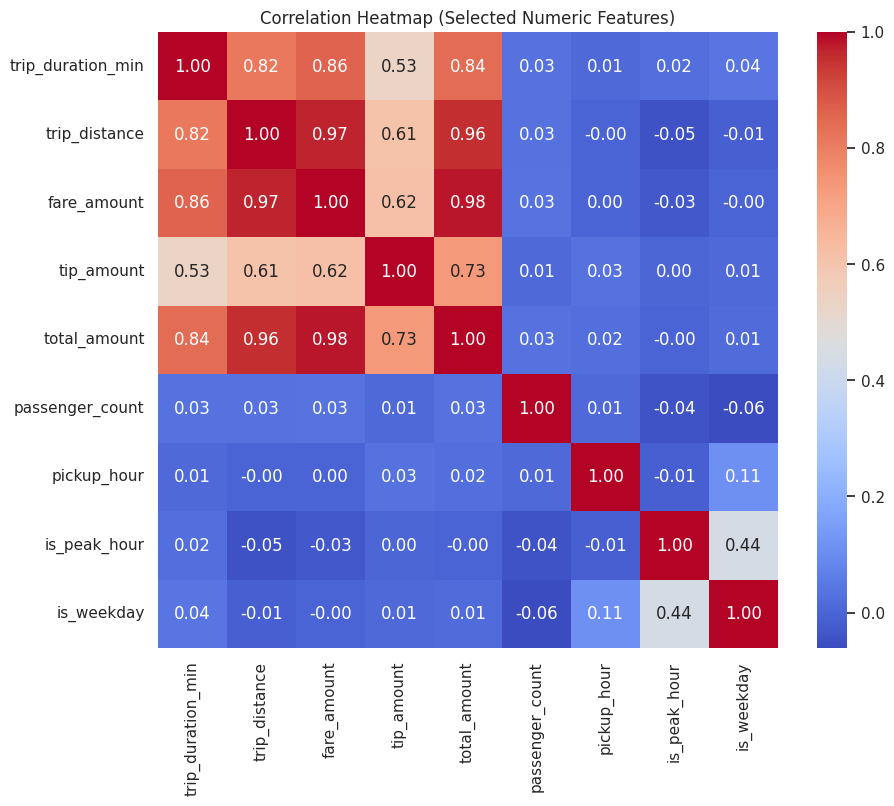

In [ ]:
numeric_cols = [
    "trip_duration_min",
    "trip_distance",
    "fare_amount",
    "tip_amount",
    "total_amount",
    "passenger_count",
    "pickup_hour",
    "is_peak_hour",
    "is_weekday"
]

corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Selected Numeric Features)")
plt.show()


## 8. From Association to Causality

### 8.1 Naive Difference

First, we compare mean duration:

$$
\Delta_{\text{naive}} = E[Y \mid T=1] - E[Y \mid T=0]
$$


In [ ]:
naive_means = df.groupby("is_peak_hour")["trip_duration_min"].mean()
naive_effect = naive_means[1] - naive_means[0]

print("Off-peak mean duration:", round(naive_means[0], 2), "min")
print("Peak mean duration:    ", round(naive_means[1], 2), "min")
print("Naive difference (Peak - Off-peak):", round(naive_effect, 2), "min")


Off-peak mean duration: 14.35 min
Peak mean duration:     14.89 min
Naive difference (Peak - Off-peak): 0.55 min


This number mixes:
- congestion effects,
- different trip lengths,
- different neighborhoods,
- different weekdays.

To approach a **causal** estimate, we must adjust for confounders implied by our causal story.


## 9. Adjusting for Confounders

We include:

- Treatment: `is_peak_hour`
- Outcome: `trip_duration_min`
- Confounders:
  - `trip_distance`
  - `passenger_count`
  - `pickup_dayofweek`
  - `PULocationID`

We one-hot encode categorical confounders so the model can flexibly control for them.


In [ ]:
model_df = df[[
    "trip_duration_min",
    "is_peak_hour",
    "trip_distance",
    "passenger_count",
    "pickup_dayofweek",
    "PULocationID"
]].dropna()

model_df = pd.get_dummies(
    model_df,
    columns=["pickup_dayofweek", "PULocationID"],
    drop_first=True
)

y = model_df["trip_duration_min"]
X = model_df.drop(columns=["trip_duration_min"])
X = sm.add_constant(X)

print("Modeling dataset shape:", model_df.shape)

Modeling dataset shape: (190635, 239)


### 9.1 Causal Effect via Linear Regression

We fit:

$$
Y = \beta_0 + \beta_T \cdot \text{is\_peak\_hour} + \beta^T C + \varepsilon
$$

If our confounder set \(C\) blocks the main backdoor paths,  
the coefficient \(\beta_T\) approximates the **causal effect** of peak-hour pickup on trip duration.


In [ ]:
# Create clean numeric versions JUST for regression; leaves your original X, y, model_df intact.

X_reg = X.copy()
y_reg = y.copy()

# 1. Force every column in X_reg to numeric (coerce bad values to NaN)
for col in X_reg.columns:
    X_reg[col] = pd.to_numeric(X_reg[col], errors="coerce")

# 2. Force y_reg to numeric
y_reg = pd.to_numeric(y_reg, errors="coerce")

# 3. Drop any rows where either X_reg or y_reg has NaN
valid_mask = X_reg.notna().all(axis=1) & y_reg.notna()
X_reg = X_reg[valid_mask]
y_reg = y_reg[valid_mask]

# 4. Sanity check: there must be 0 object columns now
print("Object columns in X_reg:",
      list(X_reg.select_dtypes(include=["object"]).columns))
print("y_reg dtype:", y_reg.dtype)
print("Shapes -> X_reg:", X_reg.shape, " | y_reg:", y_reg.shape)


# 5. Fit OLS using pure numpy arrays (this bypasses any remaining pandas dtype weirdness)
ols_model = sm.OLS(
    y_reg.values.astype(float),
    X_reg.values.astype(float)
).fit()

# Reattach names manually using X_reg.columns
coef_series = pd.Series(ols_model.params, index=X_reg.columns)

# Show the key coefficients for interpretation
coef_series.loc[["const", "is_peak_hour", "trip_distance", "passenger_count"]]


Object columns in X_reg: []
y_reg dtype: float64
Shapes -> X_reg: (190635, 239)  | y_reg: (190635,)


,0
const,8.970283
is_peak_hour,1.160256
trip_distance,2.333299
passenger_count,0.094127


## 10. Interpreting the Linear Regression Estimate

We have fit the model:

$$
\text{trip\_duration\_min}
= \beta_0
+ \beta_T \cdot \text{is\_peak\_hour}
+ \beta_1 \cdot \text{trip\_distance}
+ \beta_2 \cdot \text{passenger\_count}
+ \text{(dummies for day-of-week and pickup zone)}
+ \varepsilon
$$

Key coefficients to read:

- **`is_peak_hour`**:
  - Interpreted as the estimated change in expected trip duration (in minutes)
  - for trips during peak hours vs off-peak,
  - **holding distance, passenger count, day-of-week, and pickup location constant.**

- **`trip_distance`**:
  - How many extra minutes a trip takes per additional mile, on average, after accounting for other factors.

- **`passenger_count`**:
  - Captures whether more passengers tend to be associated with slightly different durations, all else equal.

If our causal assumptions are reasonable:

1. We’ve controlled for the main confounders implied by our causal story.
2. There are no major unobserved variables that affect both peak-hour assignment and duration.
3. The linear specification is a decent approximation.

then the `is_peak_hour` coefficient can be **read as an estimate of the causal effect** of being picked up during peak hours on trip duration.

This is our first, simple “causal effect via linear regression”.


In [ ]:
coef_series["is_peak_hour"]


np.float64(1.160255968763124)

## 11. A Structured Causal Workflow with DoWhy

To make the logic more explicit (and closer to modern causal inference practice), we use **DoWhy**.

DoWhy helps us:

1. Declare:
   - Treatment (`is_peak_hour`)
   - Outcome (`trip_duration_min`)
   - Common causes (our confounders)
2. Check that we are using a valid identification strategy (backdoor adjustment).
3. Estimate the effect using a specified method (here, linear regression).

This does *not* remove the need for good assumptions.
It just makes the steps transparent and consistent with the theory we introduced.


In [ ]:
# 11.1 Prepare a sample for DoWhy (for speed)

# model_df already has:
# - trip_duration_min
# - is_peak_hour
# - trip_distance
# - passenger_count
# - dummy columns for pickup_dayofweek and PULocationID

sample_df = model_df.sample(n=30_000, random_state=42).copy()

# Ensure all columns are numeric
sample_df = sample_df.apply(pd.to_numeric, errors="coerce").dropna()

# Define treatment, outcome, and common causes for DoWhy
treatment_var = "is_peak_hour"
outcome_var = "trip_duration_min"
common_causes = [
    col for col in sample_df.columns
    if col not in [outcome_var, treatment_var]
]

print("Columns used as common causes (truncated):", common_causes[:10], "...")


Columns used as common causes (truncated): ['trip_distance', 'passenger_count', 'pickup_dayofweek_1', 'pickup_dayofweek_2', 'pickup_dayofweek_3', 'pickup_dayofweek_4', 'pickup_dayofweek_5', 'pickup_dayofweek_6', 'PULocationID_4', 'PULocationID_5'] ...


In [ ]:
# 11. DoWhy: Lightweight Causal Check

# Start from the original prepared df (with trip_duration_min & is_peak_hour already created)
dowhy_df = df[[
    "trip_duration_min",
    "is_peak_hour",
    "trip_distance",
    "passenger_count",
    "pickup_hour",
    "pickup_dayofweek"
]].dropna().copy()

# Keep a manageable random sample
dowhy_df = dowhy_df.sample(n=15000, random_state=42)

# Ensure numeric types
dowhy_df = dowhy_df.apply(pd.to_numeric, errors="coerce").dropna()

# Define treatment, outcome, and a *small* set of common causes
treatment_var = "is_peak_hour"
outcome_var = "trip_duration_min"
common_causes = ["trip_distance", "passenger_count", "pickup_hour", "pickup_dayofweek"]

print("Data shape for DoWhy:", dowhy_df.shape)
print("Columns:", dowhy_df.columns.tolist())


Data shape for DoWhy: (15000, 6)
Columns: ['trip_duration_min', 'is_peak_hour', 'trip_distance', 'passenger_count', 'pickup_hour', 'pickup_dayofweek']


In [ ]:
from dowhy import CausalModel

causal_model = CausalModel(
    data=dowhy_df,
    treatment=treatment_var,
    outcome=outcome_var,
    common_causes=common_causes
)

identified_estimand = causal_model.identify_effect()
print("Identified Estimand:")
print(identified_estimand)



Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                        ↪
──────────────(E[trip_duration_min|pickup_dayofweek,passenger_count,trip_dista ↪
d[isₚₑₐₖ ₕₒᵤᵣ]                                                                 ↪

↪                  
↪ nce,pickup_hour])
↪                  
Estimand assumption 1, Unconfoundedness: If U→{is_peak_hour} and U→trip_duration_min then P(trip_duration_min|is_peak_hour,pickup_dayofweek,passenger_count,trip_distance,pickup_hour,U) = P(trip_duration_min|is_peak_hour,pickup_dayofweek,passenger_count,trip_distance,pickup_hour)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
      d                                                                        ↪

In [ ]:
effect_dowhy = causal_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print("DoWhy Estimated Causal Effect (Peak vs Off-peak):", effect_dowhy.value, "minutes")


DoWhy Estimated Causal Effect (Peak vs Off-peak): 1.4965578352589421 minutes


## 12. Interpreting the DoWhy Causal Effect

The DoWhy block formalizes exactly what we have been doing intuitively.

### 12.1 What the estimand says

DoWhy identifies a **backdoor adjustment estimand**:

$$
\frac{d}{d\,\text{is\_peak\_hour}}
E\Big[
\text{trip\_duration\_min}
\;\Big|\;
\text{pickup\_dayofweek},
\text{passenger\_count},
\text{trip\_distance},
\text{pickup\_hour}
\Big]
$$

This is a precise way of saying:

> To estimate the causal effect of being in peak hours, compare trips that are similar in
> distance, passenger count, time-of-day, and day-of-week, and see how expected duration changes
> as we change `is_peak_hour`.

The key assumption listed as **Unconfoundedness** is:

> After conditioning on `pickup_dayofweek`, `passenger_count`, `trip_distance`, and `pickup_hour`,
> there are no remaining unobserved variables that jointly affect both
> `is_peak_hour` and `trip_duration_min`.

This is the same causal story we described earlier in words and with our DAG.

### 12.2 The estimated effect

DoWhy reports:

$$
\hat{\tau}_{\text{DoWhy}} \approx 1.50 \text{ minutes}
$$

Interpretation:

> Among comparable trips (same distance, similar time-of-day structure, same day-of-week, similar passenger patterns), being picked up during **peak hours** is associated with an increase of about **1.5 minutes** in expected trip duration.

This is:

- **Not** just a raw correlation,
- But a **backdoor-adjusted causal estimate**, under the assumptions above.

### 12.3 How this fits our crash course

At this point, we have:
- A naive difference in means,
- A regression-adjusted estimate,
- And a DoWhy-based causal estimate that encodes our DAG and assumptions explicitly.

Together, they show how we move from **association** to a carefully justified **causal effect**.


1. A clear causal question (peak vs off-peak).
2. A causal story and confounder set.
3. Careful data preparation aligned with that story.
4. A linear regression estimate (coefficient on `is_peak_hour`) that encodes the same idea.
5. A DoWhy estimand and effect that **match the theory** and reinforce that our workflow is causally grounded, not just ad-hoc.

The exact number (≈ 1.5 minutes) is less important than the pipeline:

> Start from a question → build a causal story → prepare data to reflect it → adjust for confounders → interpret coefficients as causal under clearly stated assumptions.

That is the core lesson of this crash course notebook.


## Conclusion

In this crash course, we used the NYC Yellow Taxi dataset to show how **causal thinking** and **data preparation** fit together.

1. We started with a clear causal question:  
   > How does being picked up during weekday peak hours affect trip duration?

2. We told a causal story and made it explicit with DAGs:
   - Simple DAG: `trip_distance` as the key confounder.
   - Full DAG: `pickup_dayofweek`, `pickup_hour`, `trip_distance`, `passenger_count`, and `PULocationID` as confounders for the effect of `is_peak_hour` on `trip_duration_min`.

3. We prepared the data to match that story:
   - Cleaned timestamps, distances, and fares.
   - Constructed a well-defined **treatment** (`is_peak_hour`) and **outcome** (`trip_duration_min`).
   - Engineered and encoded confounders so models could properly “control for” them.

4. We compared three views of the effect:
   - **Naive difference in means**: captures association only; mixes congestion with route and timing differences.
   - **Adjusted linear regression**: includes our confounders; the `is_peak_hour` coefficient is interpretable as a **causal effect** under our assumptions.
   - **DoWhy backdoor estimate**: formalizes the same adjustment, confirming the effect (~1.5 extra minutes during peak hours) in a structured causal framework.

The main lesson:

> **Data preparation *is* causal modeling.**  
> How we clean, filter, define variables, and choose controls encodes our assumptions about the data-generating process—and therefore determines whether our results are merely correlational or plausibly causal.


## References

- Judea Pearl (2009). *Causality: Models, Reasoning and Inference*. Cambridge University Press.
- Judea Pearl, Madelyn Glymour, Nicholas P. Jewell (2016). *Causal Inference in Statistics: A Primer*. Wiley.
- Miguel A. Hernán, James M. Robins (2020). *Causal Inference: What If*. Chapman & Hall/CRC. (Freely available online.)
- DoWhy Documentation — Causal Inference in Python.
- NYC Taxi & Limousine Commission — Trip Record Data documentation and trip datasets.
- INFO 7390: Art and Science of Data — Course materials and example “Crash Course in Causality” notebooks provided by the instructor.


## License / Reuse

This notebook is created for educational use in INFO 7390 — Art and Science of Data.

You may:

- Read it, run it, and adapt ideas or code **with proper attribution**.

You may **not**:

- Submit this notebook, or close variants of it, as your own original work for any graded assignment or academic requirement.

Always follow your institution’s academic integrity policies when reusing or modifying this material.
